##### This notebook includes the following:

 Part One: Additional feature engineering
 
 Part Two: Handling Outliers
 
 Part Three: Baseline Model
 
 Part Four: Additional Models 
 
 Part Five: Validation 
 
 Part Six: Final Results
 
 Appendix: Validation Code
 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error,mean_squared_error

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import time

In [2]:
from pprint import pprint
import pickle

In [3]:
from sklearn import linear_model
from sklearn.svm import SVR 

In [4]:
import xgboost as xgb
from scipy.stats import pearsonr

In [5]:
def save_obj(obj, name ):
    with open('./'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

### Part One: Additional feature engineering

To provide more features, the following features are generated in this section:

1. The level of resemblance between the game name of the instance and the most popupar games in the database
    -this is defined as the minimum of the Euclidean Distances between the name vector and the ones of the best selling games (top 500 in terms of the sales volumn)
    -this feature will be used in every model except for the baseline
2. The number of developers, tags, genres, platforms as 4 additional features
    -these features will be used in every model
3. The average tfidf score of game names.
    -this will be an alternative feature to word vectors

In [6]:
#load a more recent version of dataframe with word embedding of size 50 -> df_tfidf_size50
df_new = load_obj("df_tfidf_size50")

In [7]:
df_new.head(5)

,index,product-name-slug,new-price,sales-volume,release-year,genres,name,slug,rating,developers,...,tag-first-person,tag-anime,tag-steam leaderboards,tag-sci-fi,tag-fantasy,tag-classic,tag-Others,glove_name,glove_vectors,tfidf_vectors
0,2,-30-great-games--family-party,7.88,16,2008.0,NaN,Family Party: 30 Great Games,family-party-30-great-games,0.00,NaN,...,0,0,0,0,0,0,1,30 great games family party,"[-0.011987873824790777, -0.010111511442660657,...","[-0.011001022575790482, -0.009524451159250288,..."
1,3,007--agent-under-fire,12.43,97,2002.0,NaN,James Bond 007: Agent Under Fire,james-bond-007-agent-under-fire,3.90,"Electronic Arts,Visceral Games,Electronic Arts...",...,0,0,0,0,0,0,0,007 agent under fire,"[0.011887307694712433, 0.00121297548245673, 0....","[0.011206702977183004, 0.0017279149162542512, ..."
2,4,007--everything-or-nothing,9.987066800602712,143,2004.0,[shooter],James Bond 007: Everything or Nothing,james-bond-007-everything-or-nothing,4.42,"Griptonite Games,Electronic Arts Redwood Shores",...,0,0,0,0,0,0,1,007 everything or nothing,"[0.004725774025625378, 0.005010563115603424, 0...","[0.004213719079930943, 0.004670850131650671, 0..."
3,5,007--from-russia-with-love,8.94,99,2005.0,[action],James Bond 007: From Russia with Love,james-bond-007-from-russia-with-love,3.91,"Rebellion,Visceral Games,Electronic Arts Redwo...",...,0,0,0,0,0,0,0,007 from russia with love,"[0.0049179336204960115, 0.0027296383807865355,...","[0.004056095763977971, 0.0020000662557417836, ..."
4,6,007--nightfire,38.1529028714891,255,2003.0,"Action,Shooter",James Bond 007: NightFire,james-bond-007-nightfire,3.93,[gearbox-software],...,0,0,0,0,0,0,0,007 nightfire,"[0.006097841455231769, 0.004732288683837156, 0...","[0.005381895551952365, 0.004194658129931138, 0..."


In [8]:
#add a feature -> min word distance to the best selling games
#load a more recent version of filtered_lines
filtered_lines = load_obj("filtered_lines_ver_2")

In [9]:
#sort by volumn
df_sorted_v = df_new.sort_values(by=['sales-volume'],ascending=False)

In [10]:
#take the index of the best 500
best_sell_index = df_sorted_v.iloc[:500].index

In [11]:
#calculate the min distance to these best sellers for each game
#which should signal the level of resemblence to a popular game

def cal_min_distance(target_idx, df,col_name):
    score_lst = []
    temp_distance = 999999
    for index,row in df.iterrows():
        temp_distance = 999999
        word_vector = row[col_name]
        for e in target_idx:
            #Euclidean Distance
            new_distance = np.linalg.norm(word_vector-df.loc[e,col_name])
            if new_distance < temp_distance:
                temp_distance = new_distance.copy()
        
        score_lst.append(temp_distance)
    
    return score_lst

In [12]:
distance_score = cal_min_distance(best_sell_index, df_new,'glove_vectors')

In [13]:
#should have very few game names that are the same as the best sellers
distance_score.count(0)

566

#### add the resemblence score to the dataframe

In [14]:
#add distance feature to the dataframe
df_new["best-sellers-similarity-score"] = distance_score

##### add the number of developers, tags, genres, platforms as 4 additional features

In [15]:
#to add number of developers, tags, genres, platforms as 4 additional features
genres_cols = [col for col in df_new.columns if 'genre' in col]
df_new["num_genres"] = df_new[genres_cols].sum(axis=1)

#tags
tag_cols = [col for col in df_new.columns if 'tag' in col]
df_new["num_tags"] = df_new[tag_cols].sum(axis=1)

#developers
dev_cols = [col for col in df_new.columns if 'developer' in col]
df_new["num_devs"] = df_new[dev_cols].sum(axis=1)

#available platforms
platform_cols = [col for col in df_new.columns if 'platform' in col]
df_new["num_plats"] = df_new[platform_cols].sum(axis=1)

In [16]:
save_obj(df_new,"df_10292019_analysis")

In [17]:
#try to keep df_new intact
df_touse = df_new.copy()

In [18]:
df_labels = df_touse.columns

In [19]:
df_labels

Index(['index', 'product-name-slug', 'new-price', 'sales-volume',
       'release-year', 'genres', 'name', 'slug', 'rating', 'developers',
       ...
       'tag-classic', 'tag-Others', 'glove_name', 'glove_vectors',
       'tfidf_vectors', 'best-sellers-similarity-score', 'num_genres',
       'num_tags', 'num_devs', 'num_plats'],
      dtype='object', length=170)

In [20]:
labels_delete = ['index', 'product-name-slug','sales-volume','release-year', 'genres', 'name', 
                 'slug','developers','platforms','tags','match']

In [21]:
df_touse = df_touse.drop(labels_delete,axis=1)

In [22]:
df_touse.head(5)

,new-price,rating,age,genre-action,genre-casual,genre-family,genre-sports,genre-strategy,genre-simulation,genre-arcade,...,tag-classic,tag-Others,glove_name,glove_vectors,tfidf_vectors,best-sellers-similarity-score,num_genres,num_tags,num_devs,num_plats
0,7.88,0.00,11.0,0,0,0,0,0,0,0,...,0,1,30 great games family party,"[-0.011987873824790777, -0.010111511442660657,...","[-0.011001022575790482, -0.009524451159250288,...",0.051619,1,1,1,1
1,12.43,3.90,17.0,0,0,0,0,0,0,0,...,0,0,007 agent under fire,"[0.011887307694712433, 0.00121297548245673, 0....","[0.011206702977183004, 0.0017279149162542512, ...",0.000000,1,2,2,3
2,9.987066800602712,4.42,15.0,0,0,0,0,0,0,0,...,0,1,007 everything or nothing,"[0.004725774025625378, 0.005010563115603424, 0...","[0.004213719079930943, 0.004670850131650671, 0...",0.035222,1,3,1,4
3,8.94,3.91,14.0,1,0,0,0,0,0,0,...,0,0,007 from russia with love,"[0.0049179336204960115, 0.0027296383807865355,...","[0.004056095763977971, 0.0020000662557417836, ...",0.000000,1,2,2,4
4,38.1529028714891,3.93,16.0,1,0,0,0,0,0,0,...,0,0,007 nightfire,"[0.006097841455231769, 0.004732288683837156, 0...","[0.005381895551952365, 0.004194658129931138, 0...",0.035557,2,1,1,1


In [23]:
#replace the rating of nan with 0
df_touse['rating']  = df_touse['rating'].fillna(0) 

In [24]:
#before proceeding create the feature of avg tfidf score to each instance
#load a more recent version of the score for a word embedding of size 50 (tfidf_dict_size50)
tfidf_score = load_obj("tfidf_dict_size50")

In [25]:
#example
tfidf_score[5]

{'007': 0.49219894533430375,
 'quantum': 0.5879729186215658,
 'solace': 0.6418941074503149}

In [26]:
#calculate average tfidf score
avg_tfidf_score ={}
for k,v in tfidf_score.items():
    
    if len(v.values()) > 0:
        if ('nan' in v.keys()):
            avg_tfidf_score[k] = 0
        else:
            avg_tfidf_score[k] = sum(v.values())/ float(len(v.values()))
    else:
        avg_tfidf_score[k] = 0

In [27]:
#example
avg_tfidf_score[5]

0.5740219904687281

In [28]:
df_touse['avg_tfidf_score'] = avg_tfidf_score.values()

In [29]:
#save
save_obj(avg_tfidf_score,'avg_tfidf_score_all_ver2')

### Handling Outliers

###### Data Description

In [30]:
y_plot = np.float64(df_touse["new-price"])

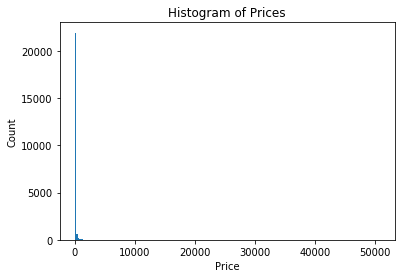

In [31]:
#the distribution of y_plot
#draw histogram
%matplotlib inline
# matplotlib histogram
n, bins, patches = plt.hist(y_plot,bins = 200)

# Add labels
plt.title('Histogram of Prices')
plt.xlabel('Price')
plt.ylabel('Count')
#maxfreq = n.max()
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
#plt.xlim(0,300)
plt.show()

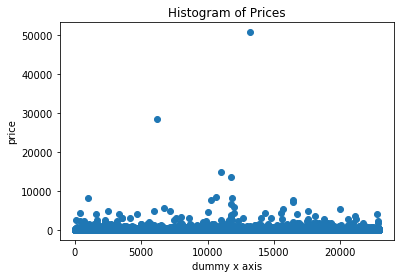

In [32]:
#scatter plot

%matplotlib inline
# matplotlib histogram
plt.scatter(range(len(y_plot)),y_plot)

# Add labels
plt.title('Histogram of Prices')
plt.xlabel('dummy x axis')
plt.ylabel('price')

plt.show()

##### ...who would pay 50K USD for a second hand game?Is it an error?
##### After some investigation, it turns out that it is not a mistake. 
##### As a matter of fact, these are the games so precious that are often sought by collecters.
##### To dig deeper:

In [33]:
df_out = df_touse[df_touse["new-price"].astype(float)>10000]

In [34]:
df_out

,new-price,rating,age,genre-action,genre-casual,genre-family,genre-sports,genre-strategy,genre-simulation,genre-arcade,...,tag-Others,glove_name,glove_vectors,tfidf_vectors,best-sellers-similarity-score,num_genres,num_tags,num_devs,num_plats,avg_tfidf_score
6200,28553.74,0.0,32.0,0,0,0,0,0,0,0,...,0,family fun fitness stadium events,"[0.002153014942534115, 0.00033724855784146606,...","[0.002746698643314864, 0.0003516241355370075, ...",0.027915,1,1,1,1,0.443429
11037,14999.99,0.0,26.0,0,0,0,0,0,0,0,...,0,magical chase,"[0.014570084853769424, 0.010166479012289054, 0...","[0.014525365446596886, 0.010165849862048765, 0...",0.035742,1,1,1,1,0.707055
11791,13499.96,0.0,26.0,0,0,0,0,0,0,0,...,0,metal slug 2 aes,"[-0.11461973558552004, -0.07269454513035757, -...","[-0.08683871191724728, -0.054874896111939124, ...",0.164990,1,1,1,1,0.484552
13191,50774.09,0.0,26.0,0,0,0,0,0,0,0,...,0,neo turf masters aes,"[-0.01584142062012118, -0.008977542080547256, ...","[-0.013678468105553884, -0.007847610262538175,...",0.044745,1,1,1,1,0.496511


The last one "neo turf masters aes" is an arcade stype golf video game released in 1996.

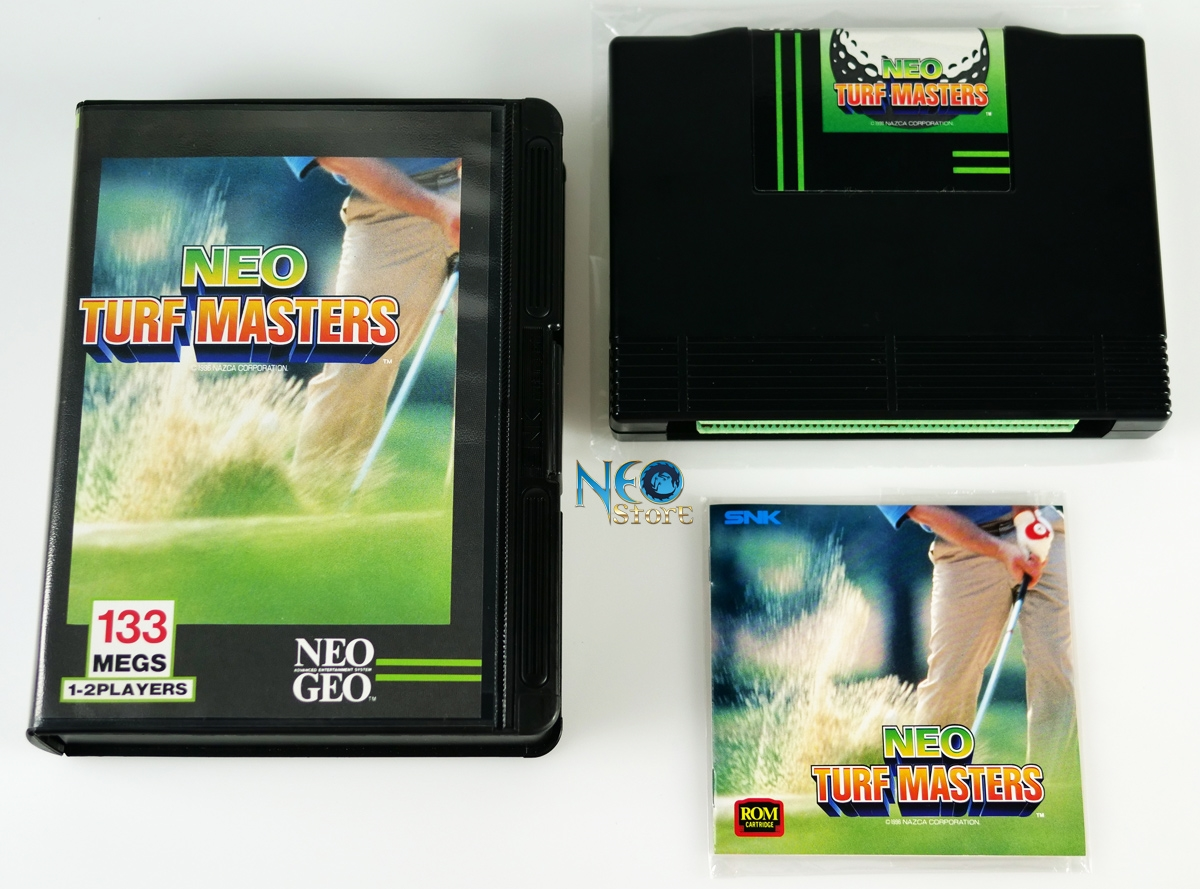

A new copy of the game, according to the official website (https://www.neostore.com/Neo-Turf-Masters-English-AES-p/491.html), will cost one 13.75K USD. It is currently out of stock (as of Nov 6th 2019).

It is worth mentioning that a manual booklet of this game alone  is listed at 1500 USD on ebay.


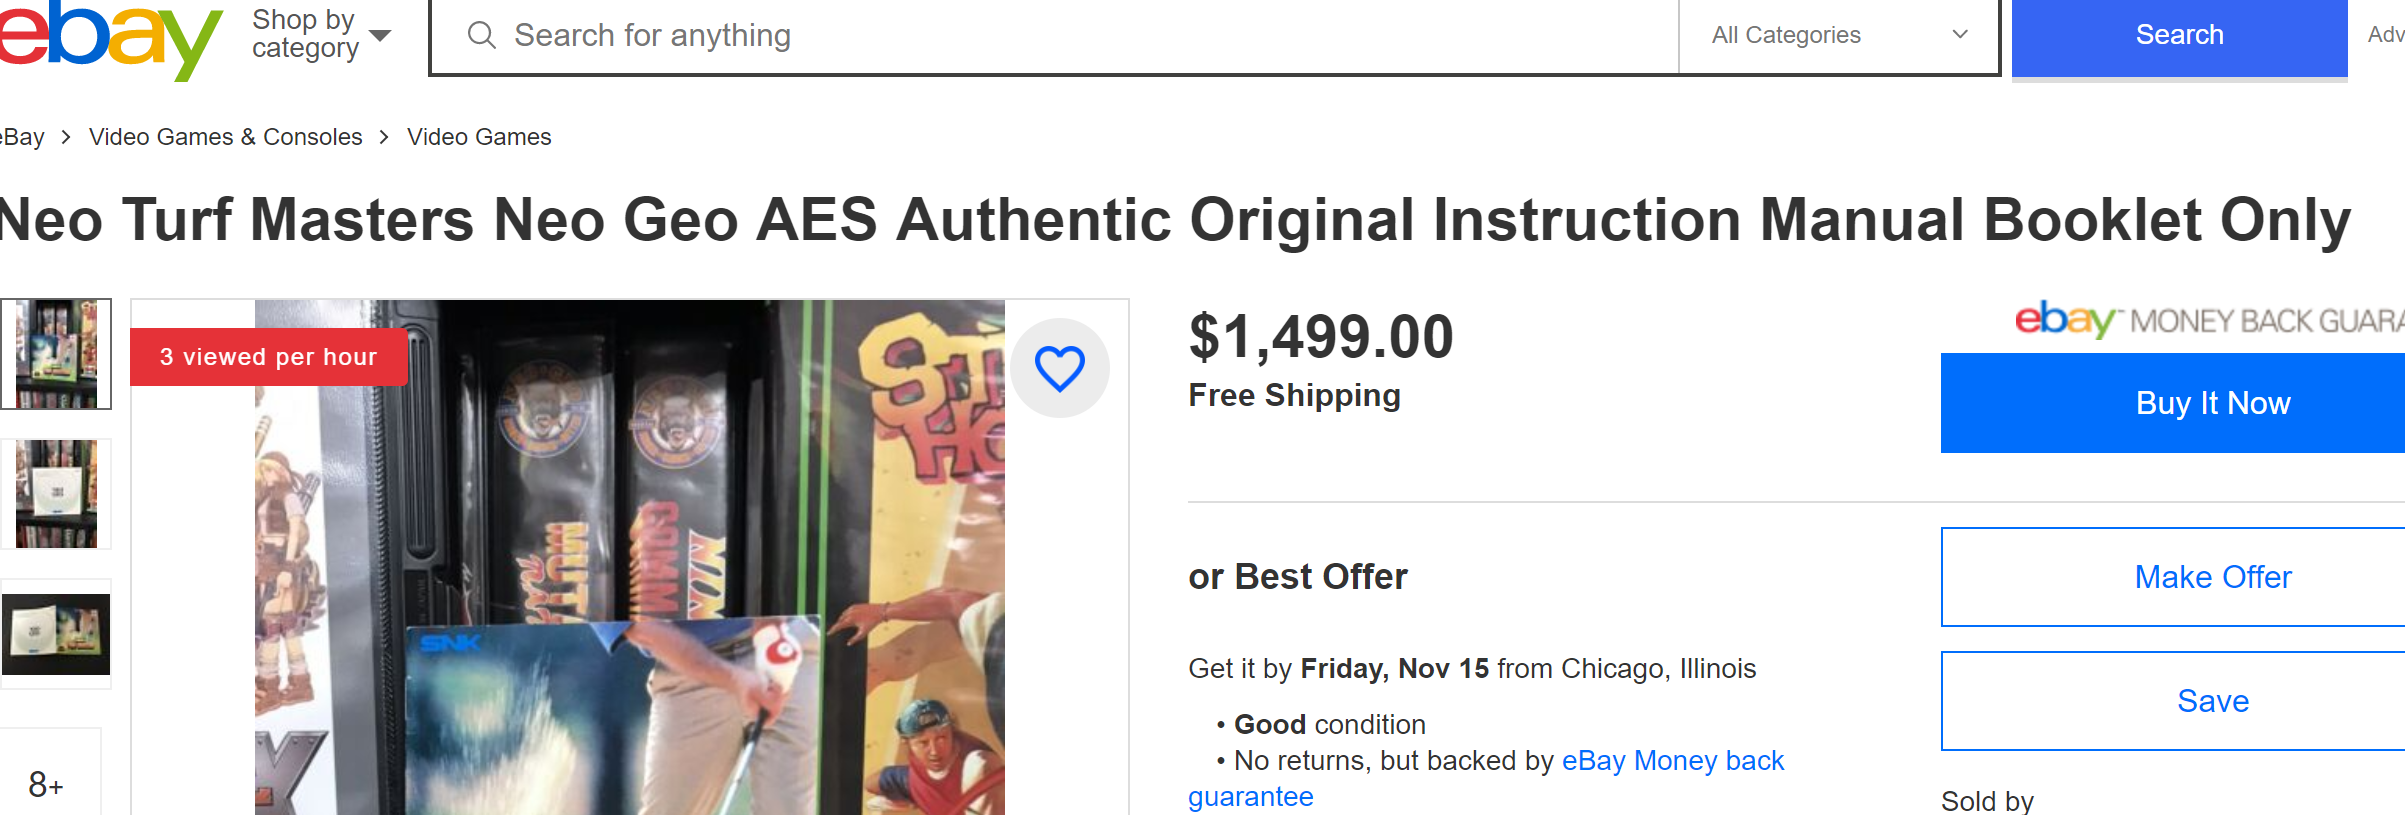

Given all the above, I am fairly confident that some people really love this game and this price is likely to be correct. Therefore, this kind of games could be true outliers.

In [35]:
#check the mean of the games now
np.mean(y_plot)

75.79260116361398

In [36]:
#check the median
np.median(y_plot)

24.8084407796102

##### To remove the outliers systematically, we will use the interquatile range method

In [37]:
df_touse["new-price"] = df_touse["new-price"].astype(float)

In [38]:
#using interquatile range method

q25, q75 = np.percentile(df_touse["new-price"] , 25), np.percentile(df_touse["new-price"], 75)
iqr = q75 - q25

# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

# identify outliers
outliers = [x for x in df_touse["new-price"] if x < lower or x > upper]

df_touse= df_touse.loc[(df_touse["new-price"]>lower) & (df_touse["new-price"]<upper)]


In [39]:
lower, upper

(-52.366865991429684, 122.52411959485781)

In [40]:
#split target and features
y = df_touse["new-price"]

In [41]:
#the length of the data now, about 2000 instances have been removed
len(y)

20404

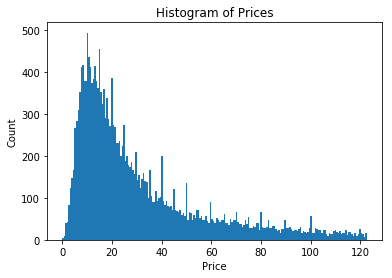

In [42]:
#the distribution of y now
y_plot = np.float64(y)

#draw histogram
%matplotlib inline
# matplotlib histogram
n, bins, patches = plt.hist(y_plot,bins = 200)

# Add labels
plt.title('Histogram of Prices')
plt.xlabel('Price')
plt.ylabel('Count')

plt.show()

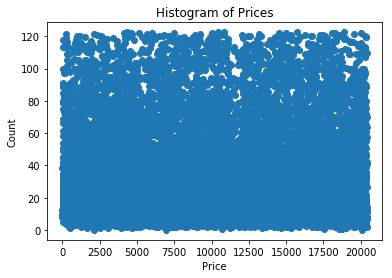

In [43]:
#scatter plot

%matplotlib inline
# matplotlib histogram
plt.scatter(range(len(y_plot)),y_plot)

# Add labels
plt.title('Histogram of Prices')
plt.xlabel('Price')
plt.ylabel('Count')

plt.show()

### Part Three: Baseline Model
The baseline model is the one where the length of the words in the game name (without English stopwords) is used as the sole feature involving game names.A random forest regressor is used to fit and train the data.

In [44]:
#train/val/test = 60/20/20
base_selector = np.random.rand(len(y))
selector_base_1 = base_selector  < 0.6
selector_base_2 = base_selector  >= 0.8

In [45]:
#base_base_model with no similarity score or word vectors, but with only the length of the game name (w/o ENG stop words)
X_bb = df_new.drop(['glove_name','glove_vectors','tfidf_vectors','best-sellers-similarity-score'],axis=1)

In [46]:
len_name = []
for n in filtered_lines:
    len_name.append(len(n))

In [47]:
X_bb["len_name"] = len_name

In [48]:
X_bb["new-price"] = X_bb["new-price"].astype(float)
X_bb= X_bb.loc[(X_bb["new-price"]>lower) & (X_bb["new-price"]<upper)]

In [49]:
X_bb = X_bb.drop(['new-price'],axis=1)

In [50]:
len(X_bb)

20404

In [51]:
X_bb = X_bb.drop(labels_delete,axis=1)

In [52]:
#replace the rating of nan with 0
X_bb['rating']  = X_bb['rating'].fillna(0) 

In [53]:
X_bb.head(5)

,rating,age,genre-action,genre-casual,genre-family,genre-sports,genre-strategy,genre-simulation,genre-arcade,genre-NA,...,tag-steam leaderboards,tag-sci-fi,tag-fantasy,tag-classic,tag-Others,num_genres,num_tags,num_devs,num_plats,len_name
0,0.00,11.0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,1,1,1,5
1,3.90,17.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,2,2,3,3
2,4.42,15.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,3,1,4,3
3,3.91,14.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,2,4,3
4,3.93,16.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,1,1,2


In [54]:
X_train_bb = X_bb[selector_base_1]
X_val_bb = X_bb[(~selector_base_1) & (~selector_base_2)]
X_test_bb = X_bb[selector_base_2]
y_train_bb = y[selector_base_1]
y_val_bb = y[(~selector_base_1) & (~selector_base_2)]
y_test_bb = y[selector_base_2]

In [55]:
#change target to float
y_train_bb = [float(x) for x in y_train_bb]
y_val_bb = [float(x) for x in y_val_bb]
y_test_bb = [float(x) for x in y_test_bb] 

In [56]:
bb_model = RandomForestRegressor(n_estimators=20, criterion='mae',max_features = 5,bootstrap=False,n_jobs = -1,random_state=123)
bb_model.fit(X_train_bb, y_train_bb) 

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)

In [57]:
#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_bb, bb_model.predict(X_train_bb))))
print('Val MAE: {}'.format(mean_absolute_error(y_val_bb, bb_model.predict(X_val_bb))))

Train MAE: 9.425987813468945
Val MAE: 16.756022267396617


In [ ]:
#fine tune
#validation hypertuning

validation_result_bb = {}
max_features_val_rf1 =[2,3,4,5,9,10,12,20,50,100]
n_estimators_val_rf1 = [20,50,100,200,500,800,1000]
random_state_val = 123
#str(f)+","+str(n)
count = 1

for f in max_features_val_rf1:
    for n in n_estimators_val_rf1 :
        print("count is: "+str(count)+" the n_estimator is: " + str(n) + " the max_feature is: " + str(f))
        start_time = time.time()
        temp_model = RandomForestRegressor(n_estimators=n, criterion='mae',max_features = f,bootstrap=False,n_jobs = -1,random_state=random_state_val)
        temp_model.fit(X_train_bb, y_train_bb) 
        train_predict = temp_model.predict(X_train_bb)
        val_predict = temp_model.predict(X_val_bb)
        train_mae = mean_absolute_error(y_train_bb, train_predict)
        val_mae = mean_absolute_error(y_val_bb, val_predict)
        run_time = time.time() - start_time
        print("count finished and it cost %s seconds " %run_time)
        print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
        validation_result_bb[f,n] = [train_mae,val_mae,run_time]
        count = count + 1

count is: 1 the n_estimator is: 20 the max_feature is: 2
count finished and it cost 18.821611881256104 seconds 
train mae is: 10.205413609247488val mae is: 16.623025229697518
count is: 2 the n_estimator is: 50 the max_feature is: 2
count finished and it cost 49.74865984916687 seconds 
train mae is: 10.145649606058val mae is: 16.587199165455043
count is: 3 the n_estimator is: 100 the max_feature is: 2
count finished and it cost 99.6573281288147 seconds 
train mae is: 10.107319874568256val mae is: 16.531633971451285
count is: 4 the n_estimator is: 200 the max_feature is: 2
count finished and it cost 197.9168975353241 seconds 
train mae is: 10.076200214485743val mae is: 16.520844235898743
count is: 5 the n_estimator is: 500 the max_feature is: 2
count finished and it cost 473.30478501319885 seconds 
train mae is: 10.008783629411747val mae is: 16.51409728323272
count is: 6 the n_estimator is: 800 the max_feature is: 2
count finished and it cost 665.2354826927185 seconds 
train mae is: 10.0

count finished and it cost 1692.071496963501 seconds 
train mae is: 9.33468052240817val mae is: 16.497132090031954
count is: 49 the n_estimator is: 1000 the max_feature is: 12
count finished and it cost 2114.6188504695892 seconds 
train mae is: 9.335494790840794val mae is: 16.49384960867584
count is: 50 the n_estimator is: 20 the max_feature is: 20
count finished and it cost 67.05189800262451 seconds 
train mae is: 9.319052497210192val mae is: 16.621573424058084
count is: 51 the n_estimator is: 50 the max_feature is: 20
count finished and it cost 147.47072458267212 seconds 
train mae is: 9.319125681079706val mae is: 16.511312852625217
count is: 52 the n_estimator is: 100 the max_feature is: 20
count finished and it cost 302.44490146636963 seconds 
train mae is: 9.322294043727648val mae is: 16.47667611486427
count is: 53 the n_estimator is: 200 the max_feature is: 20
count finished and it cost 586.3576118946075 seconds 
train mae is: 9.32236926119883val mae is: 16.461585347669583
count 

In [ ]:
save_obj(validation_result_bb,"validation_result_bb")

In [ ]:
#on the test set
#predict and score
bb_model = RandomForestRegressor(n_estimators=20, criterion='mae',max_features = 5,bootstrap=False,n_jobs = -1,random_state=123)
bb_model.fit(X_train_bb, y_train_bb)
y_test_bb_pred = bb_model.predict(X_test_bb)
print('Val MAE: {}'.format(mean_absolute_error(y_test_bb, y_test_bb_pred))

### Part Four: Additional Models

##### Additional Models to be trained:

Data:
1. Using only the similarity score as the feature based on the learned game vocabulary (base)
2. Using both mean of word vectors (embedding size = 50) and the similarity score (rf1)
3. Using both tfidf weighted word vectors (embedding size = 50) and the similarity score (rf2)
4. Using both average tfidf score (embedding size = 50) and the similarity score (rf3)

Models:
1. Random Forest (rf)
2. XGboost (xgb)
3. Linear Regression (lasso)
4. Support Vector (SVR)

Therefore, in total 16 models will be trained(train), validated(val),and tested(test).

In [58]:
#reorganizing features

#base
X_base = df_touse.drop(['new-price','glove_name','glove_vectors','tfidf_vectors','avg_tfidf_score'],axis=1)

#rf1
X_rf1 = df_touse.drop(['new-price','glove_name','tfidf_vectors','avg_tfidf_score'],axis=1)

#create rf3 with avg tfidf score
X_rf3 = df_touse.drop(['new-price','glove_name','glove_vectors'],axis=1)

In [59]:
len(X_base)

20404

In [60]:
len(X_rf1)

20404

In [61]:
#one-hot coding for the word vectors

#length of the vectors
len_v = len(X_rf1.loc[0,'glove_vectors'])

#create columns
for i in range(len_v):
    X_rf1["vector_"+str(i)] = 0

In [62]:
#project the word vectors
for index,row in X_rf1.iterrows():
    for i in range(len_v):
        temp_vector = row["glove_vectors"]
        X_rf1.loc[index,"vector_"+str(i)] = temp_vector[i]

In [63]:
len(X_rf1['best-sellers-similarity-score'])

20404

In [64]:
X_rf1 = X_rf1.drop(['glove_vectors'],axis=1)

In [65]:
X_train_base = X_base[selector_base_1]
X_val_base = X_base[(~selector_base_1) & (~selector_base_2)]
X_test_base = X_base[selector_base_2]
y_train_base = y[selector_base_1]
y_val_base = y[(~selector_base_1) & (~selector_base_2)]
y_test_base = y[selector_base_2]

#random forest
base_selector_rf = np.random.rand(len(y))
selector_rf1_1 = base_selector_rf < 0.6
selector_rf1_2 = base_selector_rf >= 0.8

X_train_rf1 = X_rf1[selector_rf1_1]
X_val_rf1 = X_rf1[(~selector_rf1_1) & (~selector_rf1_2)]
X_test_rf1 = X_rf1[selector_rf1_2]
y_train_rf1 = y[selector_rf1_1]
y_val_rf1 = y[(~selector_rf1_1) & (~selector_rf1_2)]
y_test_rf1 = y[selector_rf1_2]

In [66]:
#change target to float
y_train_base = [float(x) for x in y_train_base]
y_val_base = [float(x) for x in y_val_base]
y_test_base = [float(x) for x in y_test_base] 

In [67]:
X_rf3 =  X_rf3.drop(['tfidf_vectors'],axis=1)

In [68]:
#split for rf3
X_train_rf3 = X_rf3[selector_rf1_1]
X_val_rf3 = X_rf3[(~selector_rf1_1) & (~selector_rf1_2)]
X_test_rf3 = X_rf3[selector_rf1_2]
y_train_rf3 = y[selector_rf1_1]
y_val_rf3 = y[(~selector_rf1_1) & (~selector_rf1_2)]
y_test_rf3 = y[selector_rf1_2]

##### Proportion of the test data

In [69]:
len(y_test_base)/len(df_new)

0.18027136686881026

In [70]:
len(y_test_rf1)/len(df_new)

0.1778718206011954

##### Build up each model

base+rf

In [71]:
#fit and train

base_model = RandomForestRegressor(n_estimators=20, criterion='mae',max_features = 3,bootstrap=False,n_jobs = -1,random_state=123)
base_model.fit(X_train_base, y_train_base) 

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)

In [72]:
#top 10 features in terms of importance 

lst_importance = zip(X_base.columns, base_model.feature_importances_)
lst_imp_sorted = sorted (lst_importance, key = lambda t: t[1])[::-1]

#top 10 importance
for name, importance in lst_imp_sorted[:10]:
    print(name, "=", importance)

best-sellers-similarity-score = 0.4818344731689197
age = 0.16075563714645652
rating = 0.02303600897551306
num_plats = 0.01790779528256924
num_tags = 0.013765973976371951
num_genres = 0.009611833128560546
tag-singleplayer = 0.007917944303579443
genre-action = 0.007738794079396917
num_devs = 0.0069141642568922275
genre-sports = 0.006747316655332465


In [73]:
#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_base, base_model.predict(X_train_base))))
print('val MAE: {}'.format(mean_absolute_error(y_val_base, base_model.predict(X_val_base))))

Train MAE: 3.2629308162867128
val MAE: 18.492754269722504


rf+rf1 and rf+rf3

In [74]:
#rf+rf1
rf1_model = RandomForestRegressor(n_estimators=20, criterion='mae',max_features =2,bootstrap=False,n_jobs=-1,random_state = 123)
rf1_model.fit(X_train_rf1, y_train_rf1) 

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)

In [75]:
#to see the top 10 features

lst_importance_rf1 = zip(X_rf1.columns, rf1_model.feature_importances_)
lst_imp_sorted_rf1 = sorted (lst_importance_rf1, key = lambda t: t[1])[::-1]

#top 10 importance
for name, importance in lst_imp_sorted_rf1[:10]:
    print(name, "=", importance)

age = 0.03779310213830034
vector_48 = 0.01851801425842458
vector_23 = 0.017363037585589734
vector_32 = 0.01735225489659624
vector_27 = 0.01731129443270215
vector_49 = 0.01724634482989157
vector_29 = 0.017244863969324068
vector_35 = 0.017062549285079262
vector_30 = 0.01704543981893019
vector_42 = 0.01700297097446015


In [76]:
#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_rf1, rf1_model.predict(X_train_rf1))))
print('Val MAE: {}'.format(mean_absolute_error(y_val_rf1, rf1_model.predict(X_val_rf1))))

Train MAE: 1.7712192999915375
Val MAE: 17.928721426657578


In [77]:
#with average tfidf score

#rf+rf3

rf3_model = RandomForestRegressor(n_estimators=20, criterion='mae',max_features =2,bootstrap=False,n_jobs=-1,random_state = 123)
rf3_model.fit(X_train_rf3, y_train_rf3) 

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)

In [78]:
#top 10 features

lst_importance_rf3 = zip(X_rf3.columns, rf3_model.feature_importances_)
lst_imp_sorted_rf3 = sorted (lst_importance_rf3, key = lambda t: t[1])[::-1]

#top 10 importance
for name, importance in lst_imp_sorted_rf3[:10]:
    print(name, "=", importance)

best-sellers-similarity-score = 0.2713672655984555
avg_tfidf_score = 0.24346039933804456
age = 0.1646740279131174
rating = 0.020000172158296546
num_plats = 0.01521237781159655
num_tags = 0.01344340135253361
tag-singleplayer = 0.009321792964462911
num_genres = 0.009019368129262708
platform-pc = 0.007243848445593603
tag-multiplayer = 0.0060862760187433045


In [79]:
#check correlation between the top 2 features
similarity_score = df_touse["best-sellers-similarity-score"]
ave_tfidf_score = df_touse["avg_tfidf_score"]

corr, _ = pearsonr(similarity_score, ave_tfidf_score)
print("the correlation is %.3f" % corr)

the correlation is -0.227


In [80]:
#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_rf3, rf3_model.predict(X_train_rf3))))
print('Val MAE: {}'.format(mean_absolute_error(y_val_rf3, rf3_model.predict(X_val_rf3))))

Train MAE: 2.7747111313832
Val MAE: 17.246474069029517


##### rf+ rf2
##### load the dataset with tfidf vector and cleans it

In [81]:
#more recent version with a word embedding size of 50
#with best seller similarity score "df_10292019_analysis"
df_tfidf = load_obj('df_tfidf_size50') 

In [82]:
df_rf2 = df_tfidf.drop(labels_delete,axis=1)
#replace the rating of nan with 0
df_rf2['rating']  = df_rf2['rating'].fillna(0) 
df_rf2["best-sellers-similarity-score"] = distance_score
#remove outliers
df_rf2['new-price'] = df_rf2['new-price'].astype(float)
df_rf2 = df_rf2.loc[(df_rf2["new-price"]>lower) & (df_rf2["new-price"]<upper)]
#split target and features
y_rf2 = df_rf2["new-price"]
X_rf2 = df_rf2.drop(['new-price','glove_name'],axis=1)

In [83]:
len(y_rf2)

20404

In [84]:
#one-hot coding for the word vectors

#length of the vectors
len_v = len(X_rf2.loc[0,'tfidf_vectors'])

#create columns
for i in range(len_v):
    X_rf2["tfidf_vector_"+str(i)] = 0

In [85]:
#project the word vectors

for index,row in X_rf2.iterrows():
    temp_vector = row["tfidf_vectors"]
    if isinstance(temp_vector,int)==False:
        #print(index)
        for i in range(len_v):
            #temp_vector = row["tfidf_vectors"]
            X_rf2.loc[index,"tfidf_vector_"+str(i)] = temp_vector[i]

In [86]:
X_rf2 = X_rf2.drop(['glove_vectors',"tfidf_vectors"],axis=1)

In [87]:
len(X_rf2["best-sellers-similarity-score"])

20404

In [88]:
#data split (same mask as used before)
X_train_rf2 = X_rf2[selector_rf1_1]
X_val_rf2 = X_rf2[(~selector_rf1_1) & (~selector_rf1_2)]
X_test_rf2 = X_rf2[selector_rf1_2]
y_train_rf2 = y_rf2[selector_rf1_1]
y_val_rf2 = y_rf2[(~selector_rf1_1) & (~selector_rf1_2)]
y_test_rf2 = y_rf2[selector_rf1_2]

In [89]:
#change target to float
y_train_rf2 = [float(x) for x in y_train_rf2]
y_val_rf2 = [float(x) for x in y_val_rf2]
y_test_rf2 = [float(x) for x in y_test_rf2] 

y_train_rf1 = [float(x) for x in y_train_rf1]
y_val_rf1 = [float(x) for x in y_val_rf1]
y_test_rf1 = [float(x) for x in y_test_rf1] 

y_train_rf3 = [float(x) for x in y_train_rf3]
y_val_rf3 = [float(x) for x in y_val_rf3]
y_test_rf3 = [float(x) for x in y_test_rf3] 

In [90]:
#rf+rf2 with tfidf weighted vector features
rf2_model = RandomForestRegressor(n_estimators=50, criterion='mae',max_features = 5,bootstrap=False,n_jobs = -1,random_state=123)
rf2_model.fit(X_train_rf2, y_train_rf2) 

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)

In [91]:
#top 10 features
lst_importance_rf2 = zip(X_rf2.columns, rf2_model.feature_importances_)
lst_imp_sorted_rf2 = sorted (lst_importance_rf2, key = lambda t: t[1])[::-1]

#top 10 importance
for name, importance in lst_imp_sorted_rf2[:10]:
    print(name, "=", importance)

age = 0.05359356235478629
tfidf_vector_34 = 0.018113854885404426
tfidf_vector_30 = 0.018019997633919906
tfidf_vector_48 = 0.017817351853605973
tfidf_vector_29 = 0.017447631849376536
tfidf_vector_24 = 0.017248342871314746
tfidf_vector_38 = 0.01717209689487543
tfidf_vector_45 = 0.01699121718250094
tfidf_vector_7 = 0.016980701313707037
tfidf_vector_5 = 0.016945649559593972


In [92]:
#check correlation between one of the dimention in vectors and the best sellers similarity score
similarity_score_rf2 = X_rf2["best-sellers-similarity-score"]
vector_test_rf2 = X_rf2["tfidf_vector_30"]

corr1, _ = pearsonr(similarity_score_rf2, vector_test_rf2)
print("the correlation is %.3f" % corr1)

the correlation is 0.027


In [93]:
#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_rf2, rf2_model.predict(X_train_rf2))))
print('Val MAE: {}'.format(mean_absolute_error(y_val_rf2, rf2_model.predict(X_val_rf2))))

Train MAE: 0.3532795729556405
Val MAE: 17.37969845360615


It's obvious that when word vectors are not present, best-sellers-similarity-score is very important important (even when some information on the game names is present).
However, when we add the complete word vectors, the role of best-sellers-similarity-score is being marginalized. 
I expected the vectors to add some extra information, but not to this extent.

##### XGboost

##### xgb+base

In [94]:
model_xgb_base=xgb.XGBRegressor(random_state=123,learning_rate=0.01,max_depth = 3,objective='reg:squarederror')
model_xgb_base.fit(X_train_base, y_train_base)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [95]:
#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_base, model_xgb_base.predict(X_train_base))))
print('Val MAE: {}'.format(mean_absolute_error(y_val_base, model_xgb_base.predict(X_val_base))))

Train MAE: 17.082037199913074
Val MAE: 17.015799676560135


##### xgb+rf1

In [96]:
#run it on rf1
model_xgb_1=xgb.XGBRegressor(random_state=123,learning_rate=0.01,max_depth = 3,objective='reg:squarederror')
model_xgb_1.fit(X_train_rf1, y_train_rf1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [97]:
#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_rf1, model_xgb_1.predict(X_train_rf1))))
print('Val MAE: {}'.format(mean_absolute_error(y_val_rf1, model_xgb_1.predict(X_val_rf1))))

Train MAE: 16.91541021801591
Val MAE: 17.377531861758676


##### xgb+rf2

In [98]:
model_xgb=xgb.XGBRegressor(random_state=123,learning_rate=0.01,max_depth = 3,objective='reg:squarederror')
model_xgb.fit(X_train_rf2, y_train_rf2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [99]:
#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_rf2, model_xgb.predict(X_train_rf2))))
print('Val MAE: {}'.format(mean_absolute_error(y_val_rf2, model_xgb.predict(X_val_rf2))))

Train MAE: 16.916052829040357
Val MAE: 17.38302885462375


##### xgb+rf3

In [100]:
model_xgb=xgb.XGBRegressor(random_state=123,learning_rate=0.01,max_depth = 3,objective='reg:squarederror')
model_xgb.fit(X_train_rf3, y_train_rf3)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [101]:
#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_rf3, model_xgb.predict(X_train_rf3))))
print('Val MAE: {}'.format(mean_absolute_error(y_val_rf3, model_xgb.predict(X_val_rf3))))

Train MAE: 16.946722928728057
Val MAE: 17.352361840061267


### Linear Models (lasso)

In [102]:
#linear regression with l1 reg

#similarity
lasso_base = linear_model.Lasso(alpha=2)
lasso_base.fit(X_train_base, y_train_base)

#predict and score
print('Similarity Score Train MAE: {}'.format(mean_absolute_error(y_train_base, lasso_base.predict(X_train_base))))
print('Similarity Score Val MAE: {}'.format(mean_absolute_error(y_val_base,  lasso_base.predict(X_val_base))))

#mean vectors (rf1 set)

lasso_1 = linear_model.Lasso(alpha=2)
lasso_1.fit(X_train_rf1, y_train_rf1)

#predict and score
print('rf1 Train MAE: {}'.format(mean_absolute_error(y_train_rf1, lasso_1.predict(X_train_rf1))))
print('rf1 Val MAE: {}'.format(mean_absolute_error(y_val_rf1,  lasso_1.predict(X_val_rf1))))

#tfidf adjusted name vectors (rf2 set)

lasso_2 = linear_model.Lasso(alpha=2)
lasso_2.fit(X_train_rf2, y_train_rf2)

#predict and score
print('rf2 Train MAE: {}'.format(mean_absolute_error(y_train_rf2, lasso_2.predict(X_train_rf2))))
print('rf2 Val MAE: {}'.format(mean_absolute_error(y_val_rf2,  lasso_2.predict(X_val_rf2))))


#tfidf adjusted name vectors (rf3 set)

lasso_3 = linear_model.Lasso(alpha=2)
lasso_3.fit(X_train_rf3, y_train_rf3)

#predict and score
print('rf3 Train MAE: {}'.format(mean_absolute_error(y_train_rf3, lasso_3.predict(X_train_rf3))))
print('rf3 Val MAE: {}'.format(mean_absolute_error(y_val_rf3,  lasso_3.predict(X_val_rf3))))


Similarity Score Train MAE: 19.41911429184389
Similarity Score Val MAE: 19.209382610299002
rf1 Train MAE: 19.158741020904635
rf1 Val MAE: 19.666502847057185
rf2 Train MAE: 19.170635670353754
rf2 Val MAE: 19.696770711335226
rf3 Train MAE: 19.158741020904635
rf3 Val MAE: 19.666502847057185


### SVR

In [103]:
#similarity
SVR_base = SVR(C=1.0, epsilon=0.2)
SVR_base.fit(X_train_base,y_train_base)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [104]:
#predict and score
print('Similarity Score Train MAE: {}'.format(mean_absolute_error(y_train_base, SVR_base.predict(X_train_base))))
print('Similarity Score Val MAE: {}'.format(mean_absolute_error(y_val_base,   SVR_base.predict(X_val_base))))

Similarity Score Train MAE: 16.364871141830868
Similarity Score Val MAE: 16.33004761442434


In [105]:
#mean of the vectors (rf1)
SVR_1 = SVR(C=1.0, epsilon=0.2)
SVR_1.fit(X_train_rf1,y_train_rf1)
#predict and score
print('rf1 Train MAE: {}'.format(mean_absolute_error(y_train_rf1, SVR_1.predict(X_train_rf1))))
print('rf1 Val MAE: {}'.format(mean_absolute_error(y_val_rf1,   SVR_1.predict(X_val_rf1))))

#tfidf weighted vectors(rf2)
SVR_2 = SVR(C=1.0, epsilon=0.2)
SVR_2.fit(X_train_rf2,y_train_rf2)
#predict and score
print('rf2 Train MAE: {}'.format(mean_absolute_error(y_train_rf2, SVR_2.predict(X_train_rf2))))
print('rf2 Val MAE: {}'.format(mean_absolute_error(y_val_rf2,   SVR_2.predict(X_val_rf2))))


#tfidf weighted vectors(rf3)
SVR_3 = SVR(C=1.0, epsilon=0.2)
SVR_3.fit(X_train_rf3,y_train_rf3)
#predict and score
print('rf3 Train MAE: {}'.format(mean_absolute_error(y_train_rf3, SVR_3.predict(X_train_rf3))))
print('rf3 Val MAE: {}'.format(mean_absolute_error(y_val_rf3,   SVR_3.predict(X_val_rf3))))


rf1 Train MAE: 16.27526958479709
rf1 Val MAE: 16.637285974097882
rf2 Train MAE: 16.292583008456273
rf2 Val MAE: 16.62900756524612
rf3 Train MAE: 16.239924741078305
rf3 Val MAE: 16.596427684051577


### Part Five: Validation

Due to the length and time consumption, the code for validation have been attached to the end of this notebook for those that are curious.

The results of validation (except for the ones of linear regression) have been saved in the file validation. 

In brief, validation has been done on the val dataset and the best parameter has been chosen based on mae on the dataset (the sweetspot).

The optimal results are summarized in the following table

In [108]:
columns_table = ["rf (max_features,n_estimators)","xgb(learning_rate,max_depth,n_estimators)","SVR (C,epsilon)","lasso (alpha)"]
data = ["base","rf1","rf2","rf3"]
RF_data = [(5,50),(50,100),(50,800),(50,50)]
xgb_data = [(0.05,9,50),(0.01,9,200),(0.01,9,500),(0.01,9,200)]
SVR_data = [(20,0.2),(20,0.1),(20,0.1),(20,0.1)]
lasso_data = [0.01,0.001,0.001,0.1]

In [109]:
#create table
df_table = pd.DataFrame([RF_data,xgb_data,SVR_data,lasso_data],columns = columns_table)
df_table["data"] = data
df_table.set_index("data")

,"rf (max_features,n_estimators)","xgb(learning_rate,max_depth,n_estimators)","SVR (C,epsilon)",lasso (alpha)
data,,,,
base,"(5, 50)","(50, 100)","(50, 800)","(50, 50)"
rf1,"(0.05, 9, 50)","(0.01, 9, 200)","(0.01, 9, 500)","(0.01, 9, 200)"
rf2,"(20, 0.2)","(20, 0.1)","(20, 0.1)","(20, 0.1)"
rf3,0.01,0.001,0.001,0.1


### Part Six: Final Results

In [127]:
final_results = {}
final_results_detail = {}

In [128]:
rf_results = []

In [129]:
#similarity
base_model = RandomForestRegressor(n_estimators=50, criterion='mae',max_features =5,bootstrap=False,n_jobs=-1,random_state = 123)
base_model.fit(X_train_base, y_train_base) 
#predict and score
print('with only similarity Train MAE: {}'.format(mean_absolute_error(y_train_base, base_model.predict(X_train_base))))
y_test_pred = base_model.predict(X_test_base)
temp = mean_absolute_error(y_test_base, y_test_pred)
print('with only similarity Test MAE: {}'.format(temp))
rf_results.append(temp)
final_results_detail["rf_base"] = [y_test_base,y_test_pred] 


#rf1

rf1_model = RandomForestRegressor(n_estimators=100, criterion='mae',max_features =50,bootstrap=False,n_jobs=-1,random_state = 123)
rf1_model.fit(X_train_rf1, y_train_rf1) 
#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_rf1, rf1_model.predict(X_train_rf1))))
y_test_pred = rf1_model.predict(X_test_rf1)
temp = mean_absolute_error(y_test_rf1, y_test_pred)
print('Test MAE: {}'.format(temp))
rf_results.append(temp)
final_results_detail["rf_rf1"] = [y_test_rf1,y_test_pred] 

#rf2 with tfidf adjusted weights

rf2_model = RandomForestRegressor(n_estimators=800, criterion='mae',max_features =50,bootstrap=False,n_jobs=-1,random_state = 123)
rf2_model.fit(X_train_rf2, y_train_rf2) 
#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_rf2, rf2_model.predict(X_train_rf2))))
y_test_pred = rf2_model.predict(X_test_rf2)
temp = mean_absolute_error(y_test_rf2, y_test_pred)
print('Test MAE: {}'.format(temp))
rf_results.append(temp)
final_results_detail["rf_rf2"] = [y_test_rf2,y_test_pred] 

#rf3 with tfidf adjusted weights

rf3_model = RandomForestRegressor(n_estimators=50, criterion='mae',max_features =50,bootstrap=False,n_jobs=-1,random_state = 123)
rf3_model.fit(X_train_rf3, y_train_rf3) 
#predict and score
print('avg tfidf Train MAE: {}'.format(mean_absolute_error(y_train_rf3, rf3_model.predict(X_train_rf3))))
y_test_pred = rf3_model.predict(X_test_rf3)
temp = mean_absolute_error(y_test_rf3,y_test_pred)
print('avg tfidf Test MAE: {}'.format(temp))
rf_results.append(temp)
final_results_detail["rf_rf3"] = [y_test_rf3,y_test_pred] 


with only similarity Train MAE: 1.5814609937555604
with only similarity Test MAE: 18.709702694016986
Train MAE: 0.2357584243697322
Test MAE: 16.613676552400793
Train MAE: 0.23575842436996375
Test MAE: 16.63137473763725
avg tfidf Train MAE: 0.248580034945076
avg tfidf Test MAE: 17.42316368401684


In [130]:
final_results["RF"] = rf_results

In [131]:
xgb_results = []
temp = 0

In [132]:
#with only similarity score

model_xgb_base=xgb.XGBRegressor(random_state=123,learning_rate=0.05,max_depth = 9,n_estimators = 50,objective='reg:squarederror')
model_xgb_base.fit(X_train_base, y_train_base)

#predict and score
print('Similarity score Train MAE: {}'.format(mean_absolute_error(y_train_base, model_xgb_base.predict(X_train_base))))
y_test_pred = model_xgb_base.predict(X_test_base)
temp = mean_absolute_error(y_test_base, y_test_pred)
print('Similarity score Test MAE: {}'.format(temp))
xgb_results.append(temp)
final_results_detail["xgb_base"] = [y_test_base,y_test_pred] 

#final test on the testing dataset
#run it on rf1
model_xgb_1=xgb.XGBRegressor(random_state=123,learning_rate=0.01,max_depth = 9, n_estimators = 200, objective='reg:squarederror')
model_xgb_1.fit(X_train_rf1, y_train_rf1)
#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_rf1, model_xgb_1.predict(X_train_rf1))))
y_test_pred = model_xgb_1.predict(X_test_rf1)
temp = mean_absolute_error(y_test_rf1, y_test_pred)
print('Test MAE: {}'.format(temp))
xgb_results.append(temp)
final_results_detail["xgb_rf1"] = [y_test_rf1,y_test_pred] 

#rf2 with tfidf weighted vector features

model_xgb_2=xgb.XGBRegressor(random_state=123,learning_rate=0.01,max_depth = 9,n_estimators = 500,objective='reg:squarederror')
model_xgb_2.fit(X_train_rf2, y_train_rf2)

#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_rf2, model_xgb_2.predict(X_train_rf2))))
y_test_pred = model_xgb_2.predict(X_test_rf2)
temp = mean_absolute_error(y_test_rf2, y_test_pred)
print('Test MAE: {}'.format(temp))
xgb_results.append(temp)
final_results_detail["xgb_rf2"] = [y_test_rf2,y_test_pred] 

#rf3 with tfidf weighted vector features

model_xgb_3=xgb.XGBRegressor(random_state=123,learning_rate=0.01,max_depth = 9,n_estimators = 200,objective='reg:squarederror')
model_xgb_3.fit(X_train_rf3, y_train_rf3)

#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_rf3, model_xgb_3.predict(X_train_rf3))))
y_test_pred = model_xgb_3.predict(X_test_rf3)
temp = mean_absolute_error(y_test_rf3, y_test_pred)
print('Test MAE: {}'.format(temp))
xgb_results.append(temp)
final_results_detail["xgb_rf3"] = [y_test_rf3,y_test_pred] 

Similarity score Train MAE: 14.225411441320679
Similarity score Test MAE: 16.115422338331886
Train MAE: 11.901542507555112
Test MAE: 15.867315852344266
Train MAE: 9.47054661470137
Test MAE: 16.062656877190037
Train MAE: 13.671180597426781
Test MAE: 15.947980062621452


In [133]:
final_results["xgb"] = xgb_results

##### try  regression and svm

In [134]:
lasso_results = []

In [135]:
#result on the test set

#base
lasso_base = linear_model.Lasso(alpha=0.01)
lasso_base.fit(X_train_base, y_train_base)

#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_base, lasso_base.predict(X_train_base))))
y_test_pred = lasso_base.predict(X_test_base)
temp = mean_absolute_error(y_test_base, y_test_pred)
print('Test MAE: {}'.format(temp))
lasso_results.append(temp)
final_results_detail["lasso_base"] = [y_test_base,y_test_pred] 

#mean vectors (rf1 set)

lasso_1 = linear_model.Lasso(alpha=0.001)
lasso_1.fit(X_train_rf1, y_train_rf1)

#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_rf1, lasso_1.predict(X_train_rf1))))
y_test_pred = lasso_1.predict(X_test_rf1)
temp = mean_absolute_error(y_test_rf1,  y_test_pred)
print('Test MAE: {}'.format(temp))
lasso_results.append(temp)
final_results_detail["lasso_rf1"] = [y_test_rf1,y_test_pred] 

#tfidf adjusted name vectors (rf2 set)

lasso_2 = linear_model.Lasso(alpha=0.001)
lasso_2.fit(X_train_rf2, y_train_rf2)

#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_rf2, lasso_2.predict(X_train_rf2))))
y_test_pred = lasso_2.predict(X_test_rf2)
temp = mean_absolute_error(y_test_rf2, y_test_pred)
print('Test MAE: {}'.format(temp))
lasso_results.append(temp)
final_results_detail["lasso_rf2"] = [y_test_rf2,y_test_pred] 


#tfidf adjusted name vectors (rf3 set)

lasso_3 = linear_model.Lasso(alpha=0.01)
lasso_3.fit(X_train_rf3, y_train_rf3)

#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_rf3, lasso_3.predict(X_train_rf3))))
y_test_pred = lasso_3.predict(X_test_rf3)
temp = mean_absolute_error(y_test_rf3, y_test_pred)
print('Test MAE: {}'.format(temp))
lasso_results.append(temp)
final_results_detail["lasso_rf3"] = [y_test_rf3,y_test_pred] 

Train MAE: 18.0022627052838
Test MAE: 17.979471891733223


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Train MAE: 17.137456622503205
Test MAE: 17.52384295340689
Train MAE: 17.17229922213821
Test MAE: 17.549098060700054
Train MAE: 17.839213374455014
Test MAE: 18.115826630420234


In [136]:
final_results["lasso"] = lasso_results

In [137]:
SVR_results = []

In [138]:
#Similarity
SVR_base = SVR(C=20, epsilon=0.2)
SVR_base.fit(X_train_base, y_train_base)

#predict and score
print('Similarity Train MAE: {}'.format(mean_absolute_error(y_train_base, SVR_base.predict(X_train_base))))
y_test_pred = SVR_base.predict(X_test_base)
temp = mean_absolute_error(y_test_base,  SVR_base.predict(X_test_base))
print('Similarity Test MAE: {}'.format(temp))
SVR_results.append(temp)
final_results_detail["SVR_base"] = [y_test_base,y_test_pred] 


#for rf1 stay in rbf
#mean vectors (rf1 set)

SVR_1 = SVR(C=20, epsilon=0.1)
SVR_1.fit(X_train_rf1, y_train_rf1)

#predict and score
print('Mean Vector Train MAE: {}'.format(mean_absolute_error(y_train_rf1, SVR_1.predict(X_train_rf1))))
y_test_pred = SVR_1.predict(X_test_rf1)
temp = mean_absolute_error(y_test_rf1, y_test_pred)
print('Mean Vector Test MAE: {}'.format(temp))
SVR_results.append(temp)
final_results_detail["SVR_rf1"] = [y_test_rf1,y_test_pred] 


#tfidf adjusted name vectors (rf2 set)

SVR_2 = SVR(C=20, epsilon=1)
SVR_2.fit(X_train_rf2, y_train_rf2)

#predict and score
print('Tfidf Train MAE: {}'.format(mean_absolute_error(y_train_rf2, SVR_2.predict(X_train_rf2))))
y_test_pred = SVR_2.predict(X_test_rf2)
temp = mean_absolute_error(y_test_rf2,  y_test_pred)
print('Tfidf Test MAE: {}'.format(temp))
SVR_results.append(temp)
final_results_detail["SVR_rf2"] = [y_test_rf2,y_test_pred] 



#avg tfidf adjusted name vectors (rf2 set)

SVR_3 = SVR(C=20, epsilon=0.1)
SVR_3.fit(X_train_rf3, y_train_rf3)

#predict and score
print('Avg Tfidf Train MAE: {}'.format(mean_absolute_error(y_train_rf3, SVR_3.predict(X_train_rf3))))
y_test_pred = SVR_3.predict(X_test_rf3)
temp = mean_absolute_error(y_test_rf3,  y_test_pred)
print('avg Tfidf Test MAE: {}'.format(temp))
SVR_results.append(temp)
final_results_detail["SVR_rf3"] = [y_test_rf3,y_test_pred] 

Similarity Train MAE: 15.62855795458219
Similarity Test MAE: 15.835393509745055
Mean Vector Train MAE: 15.388501252755312
Mean Vector Test MAE: 15.81430394091175
Tfidf Train MAE: 15.477379282252086
Tfidf Test MAE: 15.844413946388915
Avg Tfidf Train MAE: 15.482664933937738
avg Tfidf Test MAE: 15.928508680061556


In [139]:
final_results["SVR"] = SVR_results

In [156]:
#second run
df_final_results = pd.DataFrame(final_results,index = data)

In [124]:
save_obj(df_final_results,"df_final_results")

In [147]:
#calculate the standard error on the absolute error
final_results_std = []
for k,v in final_results_detail.items():
    final_results_std.append(np.std(abs(v[0]-v[1])))

In [152]:
columns_final = ["rf","xgb","lasso","SVR"]

In [153]:
data_std = np.reshape(final_results_std, (4, 4)).T
df_final_results_std = pd.DataFrame(data_std,columns = columns_final, index = data)
df_final_results_std

,rf,xgb,lasso,SVR
base,19.407519,16.515167,16.196521,18.025380
rf1,15.587418,17.203178,15.860886,17.952253
rf2,15.474436,15.896656,15.844572,18.018364
rf3,17.370875,17.102290,16.178849,18.214914


In [154]:
save_obj(df_final_results_std,"df_final_results_std")

In [157]:
#compare with the mean absolute error
df_final_results

,RF,xgb,lasso,SVR
base,18.709703,16.115422,17.979472,15.835394
rf1,16.613677,15.867316,17.523843,15.814304
rf2,16.631375,16.062657,17.549098,15.844414
rf3,17.423164,15.947980,18.115827,15.928509


From the above results, there are several observations:
1. In terms of mean absolute error, all the non-linear models (rf,xgb,SVR) perform better than the linear model (lasso)
2. However, most of the time, non-linear models would produce more variance as they are more complex.
3. It's worth noting that unde the context of the same model, using the whole name vector sets usually provides a more accurate estimation (lower mae and lower std) which is outperforming the other 2 dataset (base and rf3).
4. We will take the best of each model and comparethem using boxplots on the absolute error on the test data

### Explore the results

### Appendix: Validation Code

##### Validation for baseline model

In [ ]:
validation_result = {}
max_features_val =[2,3,4,5,9,10,12,20,50,100]
n_estimators_val = [20,50,100,200,500,1000]
random_state_val = 123
count = 1

for f in max_features_val:
    for n in n_estimators_val:
        print("count is: "+str(count)+" the n_estimator is: " + str(n) + " the max_feature is: " + str(f))
        start_time = time.time()
        temp_model = RandomForestRegressor(n_estimators=n, criterion='mae',max_features = f,bootstrap=False,n_jobs = -1,random_state=random_state_val)
        temp_model.fit(X_train_base, y_train_base) 
        train_predict = temp_model.predict(X_train_base)
        val_predict = temp_model.predict(X_val_base)
        train_mae = mean_absolute_error(y_train_base, train_predict)
        val_mae = mean_absolute_error(y_val_base, val_predict)
        run_time = time.time() - start_time
        print("count finished and it cost %s seconds " %run_time)
        print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
        validation_result[f,n] = [train_mae,val_mae,run_time]
        count = count + 1


In [ ]:
#plot the hyperparameter graph

max_features_val_finish =[2,3,4,5,9,10,12,20]
n_estimators_val_finish = [20,50,100,200,500,1000]

#plot train mae
scores_train = [x[1] for x in validation_result.values()]
scores_train = np.array(scores_train).reshape(len(max_features_val_finish), len(n_estimators_val_finish))

for ind, i in enumerate(n_estimators_val_finish):
    plt.plot(n_estimators_val, scores_train[ind], label='number of estimators: ' + str(i))
plt.legend()
plt.xlabel('max_features')
plt.ylabel('n_estimators')
plt.title("Train MAE")
plt.show()

In [ ]:
#plot validation errors
scores_val = [x[2] for x in validation_result.values()]
scores_val = np.array(scores_val).reshape(len(max_features_val_finish), len(n_estimators_val_finish))
for ind, i in enumerate(n_estimators_val_finish):
    plt.plot(n_estimators_val_finish, scores_val[ind], label='number of estimators: ' + str(i))
plt.legend()
plt.xlabel('max_features')
plt.ylabel('n_estimators')
plt.title("Validation MAE")
plt.show()

In [ ]:
base_model = RandomForestRegressor(n_estimators=200, criterion='mae',max_features = 5,bootstrap=False,n_jobs = -1)
base_model.fit(X_train_base, y_train_base) 
#predict and score
print('Train MAE: {}'.format(mean_absolute_error(y_train_base, base_model.predict(X_train_base))))
print('Val MAE: {}'.format(mean_absolute_error(y_val_base, base_model.predict(X_val_base))))

In [ ]:
start_time = time.time()
total_time = time.time() - start_time
print("the loop cost " + str(total_time))

In [ ]:
val_result_base = {}
count = 1
for i in range(10):
    start_time = time.time()
    print("loop, ", i)
    base_model = RandomForestRegressor(n_estimators=200, criterion='mae',max_features = 5,bootstrap=False,n_jobs = -1)
    base_model.fit(X_train_base, y_train_base) 
    #predict and score
    train_pred = base_model.predict(X_train_base)
    mae_train = mean_absolute_error(y_train_base, train_pred)
    val_pred = base_model.predict(X_val_base)
    mae_val = mean_absolute_error(y_val_base, base_model.predict(X_val_base))
    test_pred = base_model.predict(X_test_base)
    mae_test = mean_absolute_error(y_test_base, base_model.predict(X_test_base))
    total_time = time.time() - start_time
    print("the loop cost " + str(total_time))
    print("the errors are,",mae_train,mae_val,mae_test)
    val_result_base[i] = [mae_train,mae_val,mae_test]

In [ ]:
validation_result_rf1 = {}
max_features_val_rf1 =[2,3,4,5,9,10,12,20,50,100]
n_estimators_val_rf1 = [20,50,100,200,500,800,1000]
random_state_val = 123
#str(f)+","+str(n)
count = 1

for f in max_features_val_rf1:
    for n in n_estimators_val_rf1 :
        print("count is: "+str(count)+" the n_estimator is: " + str(n) + " the max_feature is: " + str(f))
        start_time = time.time()
        temp_model = RandomForestRegressor(n_estimators=n, criterion='mae',max_features = f,bootstrap=False,n_jobs = -1,random_state=random_state_val)
        temp_model.fit(X_train_rf1, y_train_rf1) 
        train_predict = temp_model.predict(X_train_rf1)
        val_predict = temp_model.predict(X_val_rf1)
        train_mae = mean_absolute_error(y_train_rf1, train_predict)
        val_mae = mean_absolute_error(y_val_rf1, val_predict)
        run_time = time.time() - start_time
        print("count finished and it cost %s seconds " %run_time)
        print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
        validation_result[f,n] = [train_mae,val_mae,run_time]
        count = count + 1

In [ ]:
#validation hypertuning

validation_result_xgb_rf2 = {}
max_depth_xgb =[2,3,4,5,9,10,12,20,50,100]
learning_rate_xgb = [0.001,0.01,0.05,0.1]
n_estimators_val_xbg = [20,50,100,200,500,800,1000]
random_state_val = 123
#str(f)+","+str(n)
count = 1

for l in learning_rate_xgb:
    for m in max_depth_xgb:
        for n in n_estimators_val_xbg:
            print("count is: "+str(count)+"the learning rate is: "+str(l) +" the n_estimator is: " + str(n) + " the max_depth is: " + str(m))
            start_time = time.time()
            temp_model =xgb.XGBRegressor(random_state=random_state_val,learning_rate=l,max_depth = m,n_estimators = n,objective='reg:squarederror')
            temp_model.fit(X_train_rf2, y_train_rf2) 
            train_predict = temp_model.predict(X_train_rf2)
            val_predict = temp_model.predict(X_val_rf2)
            train_mae = mean_absolute_error(y_train_rf2, train_predict)
            val_mae = mean_absolute_error(y_val_rf2, val_predict)
            run_time = time.time() - start_time
            print("count finished and it cost %s seconds " %run_time)
            print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
            validation_result_xgb_rf2[l,m,n] = [train_mae,val_mae,run_time]
            count = count + 1


In [ ]:
#save the result

save_obj(validation_result_xgb_rf2,"validation_result_xgb_rf2")

In [ ]:
validation_result_xgb

In [ ]:
len(validation_result_xgb)/4

In [ ]:
#plot the hyperparameter graph
#plot train mae for learning rate 0.01
max_depth_xgb =[2,3,4,5,9,10,12,20,50,100]
learning_rate_xgb = [0.01,0.01,0.05,0.1]
n_estimators_val_xbg = [20,50,100,200,500,800,1000]

scores_train = [x[0] for x in validation_result.values()]
scores_train = np.array(scores_train[:70]).reshape(len(max_depth_xgb), len(n_estimators_val_xbg))

for ind, i in enumerate(max_depth_xgb):
    plt.plot(n_estimators_val_xbg, scores_train[ind], label='max_features: ' + str(i))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.title("Train MAE foe learning rate=%s" %0.001)
plt.show()

In [ ]:
#plot validation error
scores_val = [x[1] for x in validation_result.values()]
scores_val = np.array(scores_val[:70]).reshape(len(max_depth_xgb), len(n_estimators_val_xbg))

for ind, i in enumerate(max_depth_xgb):
    plt.plot(n_estimators_val_xbg, scores_val[ind], label='max_features: ' + str(i))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('max_features')
plt.title("Validation MAE ofr learning rate=%s" %0.001)
plt.show()


In [ ]:
#learning rate = 0.01

scores_train = [x[0] for x in validation_result_xgb_rf2.values()]
scores_train = np.array(scores_train[70:140]).reshape(len(max_depth_xgb), len(n_estimators_val_xbg))

for ind, i in enumerate(max_depth_xgb):
    plt.plot(n_estimators_val_xbg, scores_train[ind], label='max_features: ' + str(i))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.title("Train MAE foe learning rate=%s" %0.01)
plt.show()

In [ ]:
#plot validation error
scores_val = [x[1] for x in validation_result_xgb_rf2.values()]
scores_val = np.array(scores_val[70:140]).reshape(len(max_depth_xgb), len(n_estimators_val_xbg))

for ind, i in enumerate(max_depth_xgb):
    plt.plot(n_estimators_val_xbg, scores_val[ind], label='max_features: ' + str(i))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('max_features')
plt.title("Validation MAE ofr learning rate=%s" %0.01)
plt.show()

In [ ]:
#learning rate = 0.05
scores_train = [x[0] for x in validation_result_xgb_rf2.values()]
scores_train = np.array(scores_train[140:210]).reshape(len(max_depth_xgb), len(n_estimators_val_xbg))

for ind, i in enumerate(max_depth_xgb):
    plt.plot(n_estimators_val_xbg, scores_train[ind], label='max_features: ' + str(i))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.title("Train MAE foe learning rate=%s" %0.05)
plt.show()


In [ ]:
#plot validation error
scores_val = [x[1] for x in validation_result_xgb_rf2.values()]
scores_val = np.array(scores_val[140:210]).reshape(len(max_depth_xgb), len(n_estimators_val_xbg))

for ind, i in enumerate(max_depth_xgb):
    plt.plot(n_estimators_val_xbg, scores_val[ind], label='max_features: ' + str(i))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('max_features')
plt.title("Validation MAE ofr learning rate=%s" %0.05)
plt.show()

In [ ]:
#learning rate = 0.1
scores_train = [x[0] for x in validation_result_xgb_rf2.values()]
scores_train = np.array(scores_train[210:280]).reshape(len(max_depth_xgb), len(n_estimators_val_xbg))

for ind, i in enumerate(max_depth_xgb):
    plt.plot(n_estimators_val_xbg, scores_train[ind], label='max_features: ' + str(i))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.title("Train MAE foe learning rate=%s" %0.1)
plt.show()

In [ ]:
#plot validation error
scores_val = [x[1] for x in validation_result_xgb_rf2.values()]
scores_val = np.array(scores_val[210:280]).reshape(len(max_depth_xgb), len(n_estimators_val_xbg))

for ind, i in enumerate(max_depth_xgb):
    plt.plot(n_estimators_val_xbg, scores_val[ind], label='max_features: ' + str(i))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('max_features')
plt.title("Validation MAE ofr learning rate=%s" %0.1)
plt.show()

In [ ]:
#similarity score only
#validation hypertuning

validation_result_xgb_base = {}
max_depth_xgb =[2,3,4,5,9,10,12,20,50,100]
learning_rate_xgb = [0.001,0.01,0.05,0.1]
n_estimators_val_xbg = [20,50,100,200,500,800,1000]
random_state_val = 123
count = 1

for l in learning_rate_xgb:
    for m in max_depth_xgb:
        for n in n_estimators_val_xbg:
            print("count is: "+str(count)+"the learning rate is: "+str(l) +" the n_estimator is: " + str(n) + " the max_depth is: " + str(m))
            start_time = time.time()
            temp_model =xgb.XGBRegressor(random_state=random_state_val,learning_rate=l,max_depth = m,n_estimators = n,objective='reg:squarederror')
            temp_model.fit(X_train_base, y_train_base) 
            train_predict = temp_model.predict(X_train_base)
            val_predict = temp_model.predict(X_val_base)
            train_mae = mean_absolute_error(y_train_base, train_predict)
            val_mae = mean_absolute_error(y_val_base, val_predict)
            run_time = time.time() - start_time
            print("count finished and it cost %s seconds " %run_time)
            print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
            validation_result_xgb_base[l,m,n] = [train_mae,val_mae,run_time]
            count = count + 1


In [ ]:
save_obj( validation_result_xgb_base," validation_result_xgb_base")

In [ ]:
#validation hypertuning

validation_result_xgb_rf1 = {}
max_depth_xgb =[2,3,4,5,9,10,12,20,50,100]
learning_rate_xgb = [0.001,0.01,0.05,0.1]
n_estimators_val_xbg = [20,50,100,200,500,800,1000]
random_state_val = 123
count = 1

for l in learning_rate_xgb:
    for m in max_depth_xgb:
        for n in n_estimators_val_xbg:
            print("count is: "+str(count)+"the learning rate is: "+str(l) +" the n_estimator is: " + str(n) + " the max_depth is: " + str(m))
            start_time = time.time()
            temp_model =xgb.XGBRegressor(random_state=random_state_val,learning_rate=l,max_depth = m,n_estimators = n,objective='reg:squarederror')
            temp_model.fit(X_train_rf1, y_train_rf1) 
            train_predict = temp_model.predict(X_train_rf1)
            val_predict = temp_model.predict(X_val_rf1)
            train_mae = mean_absolute_error(y_train_rf1, train_predict)
            val_mae = mean_absolute_error(y_val_rf1, val_predict)
            run_time = time.time() - start_time
            print("count finished and it cost %s seconds " %run_time)
            print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
            validation_result_xgb_rf1[l,m,n] = [train_mae,val_mae,run_time]
            count = count + 1


In [ ]:
save_obj( validation_result_xgb_rf1," validation_result_xgb_rf1")

In [ ]:
#validation hypertuning

validation_result_xgb_rf3 = {}
max_depth_xgb =[2,3,4,5,9,10,12,20,50,100]
learning_rate_xgb = [0.001,0.01,0.05,0.1]
n_estimators_val_xbg = [20,50,100,200,500,800,1000]
random_state_val = 123
count = 1

for l in learning_rate_xgb:
    for m in max_depth_xgb:
        for n in n_estimators_val_xbg:
            print("count is: "+str(count)+"the learning rate is: "+str(l) +" the n_estimator is: " + str(n) + " the max_depth is: " + str(m))
            start_time = time.time()
            temp_model =xgb.XGBRegressor(random_state=random_state_val,learning_rate=l,max_depth = m,n_estimators = n,objective='reg:squarederror')
            temp_model.fit(X_train_rf3, y_train_rf3) 
            train_predict = temp_model.predict(X_train_rf3)
            val_predict = temp_model.predict(X_val_rf3)
            train_mae = mean_absolute_error(y_train_rf3, train_predict)
            val_mae = mean_absolute_error(y_val_rf3, val_predict)
            run_time = time.time() - start_time
            print("count finished and it cost %s seconds " %run_time)
            print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
            validation_result_xgb_rf3[l,m,n] = [train_mae,val_mae,run_time]
            count = count + 1


In [ ]:
save_obj(validation_result_xgb_rf3," validation_result_xgb_rf3")

In [ ]:
#fine tuning
lasso_1_val = {}
lasso_2_val = {}
alpha_lst = [0.001,0.005,0.01,0.05,0.1,0.5,1,2,5,10,20,100]

count = 1

#lasso 1
for a in alpha_lst:
    print("count is: "+str(count)+"with an alpha of: ", a)
    start_time = time.time()
    temp_model = linear_model.Lasso(alpha=a)
    temp_model.fit(X_train_rf1, y_train_rf1) 
    train_predict = temp_model.predict(X_train_rf1)
    val_predict = temp_model.predict(X_val_rf1)
    train_mae = mean_absolute_error(y_train_rf1, train_predict)
    val_mae = mean_absolute_error(y_val_rf1, val_predict)
    run_time = time.time() - start_time
    print("count finished and it cost %s seconds " %run_time)
    print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
    lasso_1_val[a] = [train_mae,val_mae,run_time]
    count = count + 1


In [ ]:
save_obj(lasso_1_val,"lasso_1_val")

In [ ]:
#lasso 2
count = 1

#lasso 1
for a in alpha_lst:
    print("count is: "+str(count)+"with an alpha of: ", a)
    start_time = time.time()
    temp_model = linear_model.Lasso(alpha=a)
    temp_model.fit(X_train_rf2, y_train_rf2) 
    train_predict = temp_model.predict(X_train_rf2)
    val_predict = temp_model.predict(X_val_rf2)
    train_mae = mean_absolute_error(y_train_rf2, train_predict)
    val_mae = mean_absolute_error(y_val_rf2, val_predict)
    run_time = time.time() - start_time
    print("count finished and it cost %s seconds " %run_time)
    print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
    lasso_2_val[a] = [train_mae,val_mae,run_time]
    count = count + 1


In [ ]:
save_obj(lasso_2_val,"lasso_2_val")

In [ ]:
#lasso 2
lasso_base_val = {}
count = 1

#lasso 1
for a in alpha_lst:
    print("count is: "+str(count)+"with an alpha of: ", a)
    start_time = time.time()
    temp_model = linear_model.Lasso(alpha=a)
    temp_model.fit(X_train_base, y_train_base) 
    train_predict = temp_model.predict(X_train_base)
    val_predict = temp_model.predict(X_val_base)
    train_mae = mean_absolute_error(y_train_base, train_predict)
    val_mae = mean_absolute_error(y_val_base, val_predict)
    run_time = time.time() - start_time
    print("count finished and it cost %s seconds " %run_time)
    print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
    lasso_base_val[a] = [train_mae,val_mae,run_time]
    count = count + 1

In [ ]:
#lasso 2
lasso_3_val = {}
count = 1

#lasso 1
for a in alpha_lst:
    print("count is: "+str(count)+"with an alpha of: ", a)
    start_time = time.time()
    temp_model = linear_model.Lasso(alpha=a)
    temp_model.fit(X_train_rf3, y_train_rf3) 
    train_predict = temp_model.predict(X_train_rf3)
    val_predict = temp_model.predict(X_val_rf3)
    train_mae = mean_absolute_error(y_train_rf3, train_predict)
    val_mae = mean_absolute_error(y_val_rf3, val_predict)
    run_time = time.time() - start_time
    print("count finished and it cost %s seconds " %run_time)
    print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
    lasso_3_val[a] = [train_mae,val_mae,run_time]
    count = count + 1

In [ ]:
# plot

#lasso 1

#plot training and validation errors

plt.plot(alpha_lst, [x[0] for x in lasso_1_val.values()], label='train mae')
plt.plot(alpha_lst, [x[1] for x in lasso_1_val.values()], label='validation mae')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title("training and validation errors")
plt.show()

alpha = 0.5 for rf1 data

In [ ]:
lasso_2_val

In [ ]:
#lasso 2

#plot training and validation errors

plt.plot(alpha_lst, [x[0] for x in lasso_2_val.values()], label='train mae')
plt.plot(alpha_lst, [x[1] for x in lasso_2_val.values()], label='validation mae')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title("training and validation errors for tfidf weighted vectors")
plt.show()

##### alpha = 0.5

### SVM

In [ ]:
#fine tuning
validation_SVR_1 = {}
c_lst =[0.001,0.01,0.5,1,2,5,10,20]
epsilon = [0.01,0.1,0.2,0.5,1,2,5]
random_state_val = 123

#rf1
count = 1

for c in c_lst:
    for e in epsilon :
        print("count is: "+str(count)+" the C is: " + str(c) + " and the epsilon is: " + str(e))
        start_time = time.time()
        temp_model = SVR(C=c, epsilon=e)
        temp_model.fit(X_train_rf1, y_train_rf1) 
        train_predict = temp_model.predict(X_train_rf1)
        val_predict = temp_model.predict(X_val_rf1)
        train_mae = mean_absolute_error(y_train_rf1, train_predict)
        val_mae = mean_absolute_error(y_val_rf1, val_predict)
        run_time = time.time() - start_time
        print("count finished and it cost %s seconds " %run_time)
        print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
        validation_SVR_1[c,e] = [train_mae,val_mae,run_time]
        count = count + 1


In [ ]:
validation_SVR_1

In [ ]:
save_obj(validation_SVR_1,"validation_SVR_1")

In [ ]:
#rf1
validation_SVR_2 = {}
count = 1

for c in c_lst:
    for e in epsilon :
        print("count is: "+str(count)+" the C is: " + str(c) + " and the epsilon is: " + str(e))
        start_time = time.time()
        temp_model = SVR(C=c, epsilon=e)
        temp_model.fit(X_train_rf2, y_train_rf2) 
        train_predict = temp_model.predict(X_train_rf2)
        val_predict = temp_model.predict(X_val_rf2)
        train_mae = mean_absolute_error(y_train_rf2, train_predict)
        val_mae = mean_absolute_error(y_val_rf2, val_predict)
        run_time = time.time() - start_time
        print("count finished and it cost %s seconds " %run_time)
        print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
        validation_SVR_2[c,e] = [train_mae,val_mae,run_time]
        count = count + 1

In [ ]:
save_obj(validation_SVR_2,"validation_SVR_2")

In [ ]:
#similarity score
validation_SVR_base = {}
count = 1

for c in c_lst:
    for e in epsilon :
        print("count is: "+str(count)+" the C is: " + str(c) + " and the epsilon is: " + str(e))
        start_time = time.time()
        temp_model = SVR(C=c, epsilon=e)
        temp_model.fit(X_train_base, y_train_base) 
        train_predict = temp_model.predict(X_train_base)
        val_predict = temp_model.predict(X_val_base)
        train_mae = mean_absolute_error(y_train_base, train_predict)
        val_mae = mean_absolute_error(y_val_base, val_predict)
        run_time = time.time() - start_time
        print("count finished and it cost %s seconds " %run_time)
        print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
        validation_SVR_base[c,e] = [train_mae,val_mae,run_time]
        count = count + 1

In [ ]:
save_obj(validation_SVR_base,"validation_SVR_base")

In [ ]:
#similarity score
validation_SVR_rf3 = {}
count = 1

for c in c_lst:
    for e in epsilon :
        print("count is: "+str(count)+" the C is: " + str(c) + " and the epsilon is: " + str(e))
        start_time = time.time()
        temp_model = SVR(C=c, epsilon=e)
        temp_model.fit(X_train_rf3 , y_train_rf3 ) 
        train_predict = temp_model.predict(X_train_rf3)
        val_predict = temp_model.predict(X_val_rf3 )
        train_mae = mean_absolute_error(y_train_rf3, train_predict)
        val_mae = mean_absolute_error(y_val_rf3, val_predict)
        run_time = time.time() - start_time
        print("count finished and it cost %s seconds " %run_time)
        print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
        validation_SVR_rf3[c,e] = [train_mae,val_mae,run_time]
        count = count + 1

In [ ]:
save_obj(validation_SVR_rf3,"validation_SVR_rf3")

In [ ]:
#plot
#c_lst =[0.001,0.01,0.5,1,2,5,10,20]
#epsilon = [0.01,0.1,0.2,0.5,1,2,5]
#lasso 1 train 
scores_train = [x[0] for x in validation_SVR_1.values()]
scores_train = np.array(scores_train).reshape(len(epsilon), len(c_lst))

for ind, i in enumerate(epsilon):
    plt.plot(c_lst, scores_train[ind], label='epsilon: ' + str(i))
plt.legend()
plt.xlabel('C')
plt.ylabel('MAE')
plt.title("Train MAE")
plt.show()


In [ ]:
#lasso 1 validation
scores_val = [x[1] for x in validation_SVR_1.values()]
scores_val = np.array(scores_val).reshape(len(epsilon), len(c_lst))

for ind, i in enumerate(epsilon):
    plt.plot(c_lst, scores_val[ind], label='epsilon: ' + str(i))
plt.legend()
plt.xlabel('C')
plt.ylabel('MAE')
plt.title("Validation MAE")
plt.show()

In [ ]:
#lasso 2 train 
scores_train = [x[0] for x in validation_SVR_2.values()]
scores_train = np.array(scores_train).reshape(len(epsilon), len(c_lst))

for ind, i in enumerate(epsilon):
    plt.plot(c_lst, scores_train[ind], label='epsilon: ' + str(i))
plt.legend()
plt.xlabel('C')
plt.ylabel('MAE')
plt.title("Train MAE")
plt.show()

In [ ]:
#lasso 2 validation
scores_val = [x[1] for x in validation_SVR_2.values()]
scores_val = np.array(scores_val).reshape(len(epsilon), len(c_lst))

for ind, i in enumerate(epsilon):
    plt.plot(c_lst, scores_val[ind], label='epsilon: ' + str(i))
plt.legend()
plt.xlabel('C')
plt.ylabel('MAE')
plt.title("Validation MAE")
plt.show()

In [ ]:
###try epsilon = 5 with C = 20 with poly with different degrees

#fine tuning
validation_SVR_poly_1 = {}
degree_lst =[1,2,3,4,5]
random_state_val = 123

#rf1
count = 1

for d in degree_lst :
    print("count is: "+str(count)+" the degree is: " + str(d))
    start_time = time.time()
    temp_model = SVR(C=20, epsilon=5,kernel = "poly",degree=d)
    temp_model.fit(X_train_rf1, y_train_rf1) 
    train_predict = temp_model.predict(X_train_rf1)
    val_predict = temp_model.predict(X_val_rf1)
    train_mae = mean_absolute_error(y_train_rf1, train_predict)
    val_mae = mean_absolute_error(y_val_rf1, val_predict)
    run_time = time.time() - start_time
    print("count finished and it cost %s seconds " %run_time)
    print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
    validation_SVR_poly_1[d] = [train_mae,val_mae,run_time]
    count = count + 1

In [ ]:
save_obj(validation_SVR_poly_1,"validation_SVR_poly_1")

In [ ]:
validation_SVR_poly_2 = {}
degree_lst =[1,2,3,4,5]
#rf1
count = 1

for d in degree_lst :
    print("count is: "+str(count)+" the degree is: " + str(d))
    start_time = time.time()
    temp_model = SVR(C=20, epsilon=5,kernel = "poly",degree=d)
    temp_model.fit(X_train_rf2, y_train_rf2) 
    train_predict = temp_model.predict(X_train_rf2)
    val_predict = temp_model.predict(X_val_rf2)
    train_mae = mean_absolute_error(y_train_rf2, train_predict)
    val_mae = mean_absolute_error(y_val_rf2, val_predict)
    run_time = time.time() - start_time
    print("count finished and it cost %s seconds " %run_time)
    print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
    validation_SVR_poly_2[d] = [train_mae,val_mae,run_time]
    count = count + 1


In [ ]:
validation_SVR_poly_2 = {}
degree_lst =[1,2,3,4,5]
#rf1
count = 1

for d in degree_lst :
    print("count is: "+str(count)+" the degree is: " + str(d))
    start_time = time.time()
    temp_model = SVR(C=20, epsilon=5,kernel = "poly",degree=d)
    temp_model.fit(X_train_rf2, y_train_rf2) 
    train_predict = temp_model.predict(X_train_rf2)
    val_predict = temp_model.predict(X_val_rf2)
    train_mae = mean_absolute_error(y_train_rf2, train_predict)
    val_mae = mean_absolute_error(y_val_rf2, val_predict)
    run_time = time.time() - start_time
    print("count finished and it cost %s seconds " %run_time)
    print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
    validation_SVR_poly_2[d] = [train_mae,val_mae,run_time]
    count = count + 1


In [ ]:
save_obj(validation_SVR_poly_2,"validation_SVR_poly_2")


In [ ]:
validation_SVR_poly_3 = {}
degree_lst =[1,2,3,4,5]
#rf1
count = 1

for d in degree_lst :
    print("count is: "+str(count)+" the degree is: " + str(d))
    start_time = time.time()
    temp_model = SVR(C=20, epsilon=5,kernel = "poly",degree=d)
    temp_model.fit(X_train_rf3, y_train_rf3) 
    train_predict = temp_model.predict(X_train_rf3)
    val_predict = temp_model.predict(X_val_rf3)
    train_mae = mean_absolute_error(y_train_rf3, train_predict)
    val_mae = mean_absolute_error(y_val_rf3, val_predict)
    run_time = time.time() - start_time
    print("count finished and it cost %s seconds " %run_time)
    print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
    validation_SVR_poly_3[d] = [train_mae,val_mae,run_time]
    count = count + 1

In [ ]:
save_obj(validation_SVR_poly_3,"validation_SVR_poly_3")


In [ ]:
#similarity(base)

validation_SVR_poly_base = {}
degree_lst =[1,2,3,4,5]
#rf1
count = 1

for d in degree_lst :
    print("count is: "+str(count)+" the degree is: " + str(d))
    start_time = time.time()
    temp_model = SVR(C=20, epsilon=5,kernel = "poly",degree=d)
    temp_model.fit(X_train_base, y_train_base) 
    train_predict = temp_model.predict(X_train_base)
    val_predict = temp_model.predict(X_val_base)
    train_mae = mean_absolute_error(y_train_base, train_predict)
    val_mae = mean_absolute_error(y_val_base, val_predict)
    run_time = time.time() - start_time
    print("count finished and it cost %s seconds " %run_time)
    print("train mae is: " + str(train_mae) + "val mae is: " + str(val_mae))
    validation_SVR_poly_base[d] = [train_mae,val_mae,run_time]
    count = count + 1

In [ ]:
save_obj(validation_SVR_poly_base,"validation_SVR_poly_base")